In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten

# Load Data 

In [2]:
df = pd.read_csv('Preprocessed Data 3 Mar 2021.csv', index_col = 0)
df.head(5)

,Speed (km/h),Latitude coordinate (degrees),Longitude coordinate (degrees),Altitude (meters),Vertical accuracy (degrees),Horizontal accuracy (degrees),Course (degrees),Difcourse: course variation (degrees),Acceleration in X filtered by KF (Gs),Acceleration in Y filtered by KF (Gs),...,no speed limit,no lanes number,Type of road_motorway,Type of road_motorway_link,Type of road_primary,Type of road_primary_link,Type of road_tertiary_link,AGGRESSIVE,DROWSY,NORMAL
0,64.5,40.512924,-3.404577,612.5,4,5,331.9,0.000,-0.030,-0.015,...,0,0,0,0,0,0,0,0,0,1
1,63.6,40.513065,-3.404680,612.9,4,5,330.8,1.055,0.026,-0.012,...,0,0,0,0,0,0,0,0,0,1
2,62.2,40.513210,-3.404772,613.3,4,5,330.8,1.055,-0.021,-0.018,...,0,0,0,0,0,0,0,0,0,1
3,60.9,40.513348,-3.404868,613.5,3,5,330.1,0.703,0.025,0.006,...,0,0,0,0,0,0,0,0,0,1
4,61.2,40.513477,-3.404971,613.8,3,5,329.4,1.406,0.014,-0.031,...,0,0,0,0,0,0,0,0,0,1


# K-Fold Cross Validation

In [3]:
from sklearn.model_selection import KFold
X = df.iloc[:,:-3]
Y = df.iloc[:,-3:]
kf = KFold(n_splits=5, random_state=4, shuffle=True)

# Training

In [4]:
count = 0

for train_index, test_index in kf.split(X):
    print('Fold: ' + str(count))

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1],1)
    X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1],1)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40)

    model = keras.Sequential()
    
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) 
    model.add(Conv2D(1, kernel_size=(1,3), strides=(1,1), padding='valid', activation='relu', input_shape = input_shape))
    model.add(MaxPool2D(pool_size=(1,1)))
    
    # flatten output of conv
    model.add(Flatten())
    #adding dropout layer to reduce overfitting
    model.add(Dropout(0.001))
    
    # hidden layer
    model.add(Dense(92, activation='relu'))
    model.add(Dropout(5e-5))
    model.add(BatchNormalization())

    model.add(Dense(52, activation='relu'))
    model.add(Dropout(0.0005))
    model.add(BatchNormalization())
    
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.0005))
    model.add(BatchNormalization())

    model.add(Dense(68, activation='relu'))
    model.add(Dropout(0.005))
    model.add(BatchNormalization())
    
    model.add(Dense(72, activation='relu'))
    model.add(Dropout(0.05))
    model.add(BatchNormalization())
    
    # output layer
    model.add(Dense(3, activation='softmax'))

    optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics = 'accuracy')

    model.summary()
    
    history = model.fit(X_train, Y_train, 
                    validation_data=(X_test, Y_test), 
                    #batch_size = 22,
                    callbacks=[early_stopping],
                    epochs=600)
    
    if count == 0:
        history_fold_0 = pd.DataFrame(history.history)
    elif count == 1:
        history_fold_1 = pd.DataFrame(history.history)
    elif count == 2:
        history_fold_2 = pd.DataFrame(history.history)
    elif count == 3:
        history_fold_3 = pd.DataFrame(history.history)
    elif count == 4:
        history_fold_4 = pd.DataFrame(history.history)
    
    count += 1

Fold: 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 38, 1)          4         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 38, 1)          0         
_________________________________________________________________
flatten (Flatten)            (None, 38)                0         
_________________________________________________________________
dropout (Dropout)            (None, 38)                0         
_________________________________________________________________
dense (Dense)                (None, 92)                3588      
_________________________________________________________________
dropout_1 (Dropout)          (None, 92)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 92)         

Epoch 94/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1504 - accuracy: 0.9429 - val_loss: 0.1325 - val_accuracy: 0.9553
Epoch 95/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1494 - accuracy: 0.9434 - val_loss: 0.1441 - val_accuracy: 0.9481
Epoch 96/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1442 - accuracy: 0.9456 - val_loss: 0.1271 - val_accuracy: 0.9553
Epoch 97/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1538 - accuracy: 0.9436 - val_loss: 0.1195 - val_accuracy: 0.9601
Epoch 98/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1513 - accuracy: 0.9431 - val_loss: 0.1357 - val_accuracy: 0.9517
Epoch 99/600
769/769 [==============================] - 3s 5ms/step - loss: 0.1430 - accuracy: 0.9482 - val_loss: 0.1232 - val_accuracy: 0.9575
Epoch 100/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1459 - accuracy: 0.9458 - val_loss: 0.1357 - val_accuracy

Epoch 5/600
769/769 [==============================] - 4s 5ms/step - loss: 0.4955 - accuracy: 0.7852 - val_loss: 0.4831 - val_accuracy: 0.7850
Epoch 6/600
769/769 [==============================] - 4s 5ms/step - loss: 0.4580 - accuracy: 0.8059 - val_loss: 0.3553 - val_accuracy: 0.8504
Epoch 7/600
769/769 [==============================] - 4s 5ms/step - loss: 0.4252 - accuracy: 0.8217 - val_loss: 0.3761 - val_accuracy: 0.8440
Epoch 8/600
769/769 [==============================] - 4s 5ms/step - loss: 0.4067 - accuracy: 0.8329 - val_loss: 0.4501 - val_accuracy: 0.8038
Epoch 9/600
769/769 [==============================] - 4s 5ms/step - loss: 0.3755 - accuracy: 0.8468 - val_loss: 0.3416 - val_accuracy: 0.8617
Epoch 10/600
769/769 [==============================] - 4s 5ms/step - loss: 0.3550 - accuracy: 0.8551 - val_loss: 0.3167 - val_accuracy: 0.8663
Epoch 11/600
769/769 [==============================] - 4s 5ms/step - loss: 0.3416 - accuracy: 0.8630 - val_loss: 0.3370 - val_accuracy: 0.86

Epoch 62/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1571 - accuracy: 0.9392 - val_loss: 0.1329 - val_accuracy: 0.9486
Epoch 63/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1571 - accuracy: 0.9398 - val_loss: 0.2222 - val_accuracy: 0.9120
Epoch 64/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1486 - accuracy: 0.9447 - val_loss: 0.1089 - val_accuracy: 0.9582
Epoch 65/600
769/769 [==============================] - 3s 5ms/step - loss: 0.1500 - accuracy: 0.9453 - val_loss: 0.1596 - val_accuracy: 0.9395
Epoch 66/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1540 - accuracy: 0.9421 - val_loss: 0.1675 - val_accuracy: 0.9349
Epoch 67/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1491 - accuracy: 0.9452 - val_loss: 0.1155 - val_accuracy: 0.9530
Epoch 68/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1537 - accuracy: 0.9425 - val_loss: 0.1765 - val_accuracy:

Epoch 119/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1186 - accuracy: 0.9562 - val_loss: 0.1141 - val_accuracy: 0.9610
Epoch 120/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1132 - accuracy: 0.9587 - val_loss: 0.1054 - val_accuracy: 0.9605
Epoch 121/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1234 - accuracy: 0.9554 - val_loss: 0.0772 - val_accuracy: 0.9736
Epoch 122/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1197 - accuracy: 0.9561 - val_loss: 0.0932 - val_accuracy: 0.9654
Epoch 123/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1116 - accuracy: 0.9589 - val_loss: 0.1093 - val_accuracy: 0.9615
Epoch 124/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1124 - accuracy: 0.9592 - val_loss: 0.1019 - val_accuracy: 0.9618
Epoch 125/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1134 - accuracy: 0.9579 - val_loss: 0.0984 - val_ac

769/769 [==============================] - 4s 5ms/step - loss: 0.8282 - accuracy: 0.6006 - val_loss: 0.7300 - val_accuracy: 0.6763
Epoch 2/600
769/769 [==============================] - 3s 4ms/step - loss: 0.6517 - accuracy: 0.6990 - val_loss: 0.5731 - val_accuracy: 0.7427
Epoch 3/600
769/769 [==============================] - 3s 4ms/step - loss: 0.5714 - accuracy: 0.7408 - val_loss: 0.5320 - val_accuracy: 0.7559
Epoch 4/600
769/769 [==============================] - 3s 4ms/step - loss: 0.5171 - accuracy: 0.7698 - val_loss: 0.4619 - val_accuracy: 0.7946
Epoch 5/600
769/769 [==============================] - 3s 4ms/step - loss: 0.4820 - accuracy: 0.7885 - val_loss: 0.5289 - val_accuracy: 0.7609
Epoch 6/600
769/769 [==============================] - 3s 4ms/step - loss: 0.4521 - accuracy: 0.8062 - val_loss: 0.4532 - val_accuracy: 0.7998
Epoch 7/600
769/769 [==============================] - 3s 4ms/step - loss: 0.4268 - accuracy: 0.8187 - val_loss: 0.3913 - val_accuracy: 0.8260
Epoch 8/600

769/769 [==============================] - 3s 4ms/step - loss: 0.1895 - accuracy: 0.9284 - val_loss: 0.1736 - val_accuracy: 0.9328
Epoch 59/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1881 - accuracy: 0.9274 - val_loss: 0.1604 - val_accuracy: 0.9423
Epoch 60/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1847 - accuracy: 0.9288 - val_loss: 0.1654 - val_accuracy: 0.9401
Epoch 61/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1860 - accuracy: 0.9292 - val_loss: 0.1769 - val_accuracy: 0.9346
Epoch 62/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1878 - accuracy: 0.9281 - val_loss: 0.1534 - val_accuracy: 0.9455
Epoch 63/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1873 - accuracy: 0.9301 - val_loss: 0.1574 - val_accuracy: 0.9405
Epoch 64/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1911 - accuracy: 0.9279 - val_loss: 0.2296 - val_accuracy: 0.9109
Epoch

Epoch 115/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1434 - accuracy: 0.9450 - val_loss: 0.1478 - val_accuracy: 0.9497
Epoch 116/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1441 - accuracy: 0.9458 - val_loss: 0.1356 - val_accuracy: 0.9535
Epoch 117/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1443 - accuracy: 0.9466 - val_loss: 0.1262 - val_accuracy: 0.9574
Epoch 118/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1422 - accuracy: 0.9470 - val_loss: 0.1278 - val_accuracy: 0.9533
Epoch 119/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1420 - accuracy: 0.9471 - val_loss: 0.1587 - val_accuracy: 0.9439
Epoch 120/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1426 - accuracy: 0.9464 - val_loss: 0.1361 - val_accuracy: 0.9536
Epoch 121/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1402 - accuracy: 0.9473 - val_loss: 0.1403 - val_ac

Epoch 9/600
769/769 [==============================] - 3s 4ms/step - loss: 0.4921 - accuracy: 0.7825 - val_loss: 0.5091 - val_accuracy: 0.7736
Epoch 10/600
769/769 [==============================] - 3s 4ms/step - loss: 0.4623 - accuracy: 0.7997 - val_loss: 0.4174 - val_accuracy: 0.8126
Epoch 11/600
769/769 [==============================] - 3s 4ms/step - loss: 0.4360 - accuracy: 0.8110 - val_loss: 0.4223 - val_accuracy: 0.8191
Epoch 12/600
769/769 [==============================] - 3s 4ms/step - loss: 0.4110 - accuracy: 0.8244 - val_loss: 0.3685 - val_accuracy: 0.8409
Epoch 13/600
769/769 [==============================] - 3s 4ms/step - loss: 0.3961 - accuracy: 0.8325 - val_loss: 0.4101 - val_accuracy: 0.8201
Epoch 14/600
769/769 [==============================] - 3s 4ms/step - loss: 0.3829 - accuracy: 0.8369 - val_loss: 0.3383 - val_accuracy: 0.8556
Epoch 15/600
769/769 [==============================] - 3s 4ms/step - loss: 0.3673 - accuracy: 0.8455 - val_loss: 0.3668 - val_accuracy: 

Epoch 66/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1910 - accuracy: 0.9269 - val_loss: 0.2156 - val_accuracy: 0.9201
Epoch 67/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1857 - accuracy: 0.9289 - val_loss: 0.1515 - val_accuracy: 0.9440
Epoch 68/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1834 - accuracy: 0.9316 - val_loss: 0.2052 - val_accuracy: 0.9250
Epoch 69/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1837 - accuracy: 0.9294 - val_loss: 0.2039 - val_accuracy: 0.9253
Epoch 70/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1832 - accuracy: 0.9291 - val_loss: 0.1609 - val_accuracy: 0.9353
Epoch 71/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1818 - accuracy: 0.9308 - val_loss: 0.1520 - val_accuracy: 0.9419
Epoch 72/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1816 - accuracy: 0.9305 - val_loss: 0.1545 - val_accuracy:

Epoch 123/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1458 - accuracy: 0.9449 - val_loss: 0.1528 - val_accuracy: 0.9450
Epoch 124/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1482 - accuracy: 0.9451 - val_loss: 0.1310 - val_accuracy: 0.9530
Epoch 125/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1397 - accuracy: 0.9471 - val_loss: 0.1234 - val_accuracy: 0.9569
Epoch 126/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1342 - accuracy: 0.9495 - val_loss: 0.1374 - val_accuracy: 0.9519
Epoch 127/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1475 - accuracy: 0.9448 - val_loss: 0.1221 - val_accuracy: 0.9593
Epoch 128/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1452 - accuracy: 0.9459 - val_loss: 0.1464 - val_accuracy: 0.9449
Epoch 129/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1389 - accuracy: 0.9489 - val_loss: 0.1421 - val_ac

769/769 [==============================] - 3s 4ms/step - loss: 0.1104 - accuracy: 0.9607 - val_loss: 0.1074 - val_accuracy: 0.9629
Epoch 236/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1049 - accuracy: 0.9607 - val_loss: 0.0992 - val_accuracy: 0.9658
Epoch 237/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1095 - accuracy: 0.9599 - val_loss: 0.1360 - val_accuracy: 0.9528
Epoch 238/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1053 - accuracy: 0.9615 - val_loss: 0.1344 - val_accuracy: 0.9527
Epoch 239/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1138 - accuracy: 0.9585 - val_loss: 0.1487 - val_accuracy: 0.9488
Epoch 240/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1122 - accuracy: 0.9604 - val_loss: 0.1227 - val_accuracy: 0.9571
Epoch 241/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1083 - accuracy: 0.9611 - val_loss: 0.1221 - val_accuracy: 0.9582

769/769 [==============================] - 3s 3ms/step - loss: 0.3045 - accuracy: 0.8780 - val_loss: 0.2789 - val_accuracy: 0.8847
Epoch 15/600
769/769 [==============================] - 3s 4ms/step - loss: 0.2914 - accuracy: 0.8844 - val_loss: 0.2592 - val_accuracy: 0.8985
Epoch 16/600
769/769 [==============================] - 3s 3ms/step - loss: 0.2871 - accuracy: 0.8864 - val_loss: 0.2632 - val_accuracy: 0.8964
Epoch 17/600
769/769 [==============================] - 3s 3ms/step - loss: 0.2791 - accuracy: 0.8887 - val_loss: 0.2430 - val_accuracy: 0.9070
Epoch 18/600
769/769 [==============================] - 3s 3ms/step - loss: 0.2685 - accuracy: 0.8950 - val_loss: 0.2684 - val_accuracy: 0.8918
Epoch 19/600
769/769 [==============================] - 3s 3ms/step - loss: 0.2658 - accuracy: 0.8940 - val_loss: 0.2354 - val_accuracy: 0.9096
Epoch 20/600
769/769 [==============================] - 3s 4ms/step - loss: 0.2628 - accuracy: 0.8970 - val_loss: 0.2295 - val_accuracy: 0.9089
Epoch

Epoch 71/600
769/769 [==============================] - 3s 3ms/step - loss: 0.1540 - accuracy: 0.9421 - val_loss: 0.1878 - val_accuracy: 0.9294
Epoch 72/600
769/769 [==============================] - 3s 3ms/step - loss: 0.1603 - accuracy: 0.9397 - val_loss: 0.1845 - val_accuracy: 0.9307
Epoch 73/600
769/769 [==============================] - 3s 3ms/step - loss: 0.1544 - accuracy: 0.9407 - val_loss: 0.1671 - val_accuracy: 0.9393
Epoch 74/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1475 - accuracy: 0.9448 - val_loss: 0.1510 - val_accuracy: 0.9434
Epoch 75/600
769/769 [==============================] - 3s 3ms/step - loss: 0.1519 - accuracy: 0.9436 - val_loss: 0.1577 - val_accuracy: 0.9421
Epoch 76/600
769/769 [==============================] - 3s 3ms/step - loss: 0.1508 - accuracy: 0.9453 - val_loss: 0.1592 - val_accuracy: 0.9427
Epoch 77/600
769/769 [==============================] - 3s 3ms/step - loss: 0.1468 - accuracy: 0.9458 - val_loss: 0.1977 - val_accuracy:

Epoch 128/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1205 - accuracy: 0.9549 - val_loss: 0.1310 - val_accuracy: 0.9535
Epoch 129/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1195 - accuracy: 0.9569 - val_loss: 0.1215 - val_accuracy: 0.9579
Epoch 130/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1218 - accuracy: 0.9553 - val_loss: 0.1229 - val_accuracy: 0.9574
Epoch 131/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1129 - accuracy: 0.9587 - val_loss: 0.1040 - val_accuracy: 0.9623
Epoch 132/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1176 - accuracy: 0.9575 - val_loss: 0.1192 - val_accuracy: 0.9611
Epoch 133/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1211 - accuracy: 0.9560 - val_loss: 0.1150 - val_accuracy: 0.9597
Epoch 134/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1237 - accuracy: 0.9549 - val_loss: 0.1073 - val_ac

769/769 [==============================] - 3s 4ms/step - loss: 0.0907 - accuracy: 0.9673 - val_loss: 0.1055 - val_accuracy: 0.9673
Epoch 241/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0940 - accuracy: 0.9669 - val_loss: 0.2110 - val_accuracy: 0.9292
Epoch 242/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0934 - accuracy: 0.9668 - val_loss: 0.1090 - val_accuracy: 0.9634
Epoch 243/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0857 - accuracy: 0.9701 - val_loss: 0.1087 - val_accuracy: 0.9676
Epoch 244/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0885 - accuracy: 0.9684 - val_loss: 0.1097 - val_accuracy: 0.9642
Epoch 245/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0915 - accuracy: 0.9668 - val_loss: 0.1061 - val_accuracy: 0.9652
Epoch 246/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0950 - accuracy: 0.9671 - val_loss: 0.1185 - val_accuracy: 0.9634

# Final Result

### Fold 1

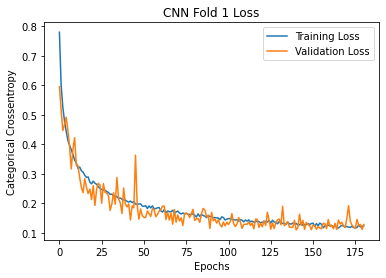

In [5]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_0.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('CNN Fold 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

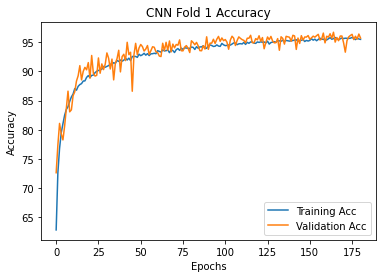

In [6]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_0.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('CNN Fold 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 2

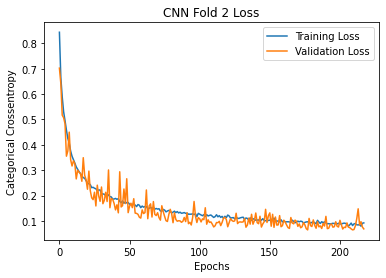

In [7]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_1.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('CNN Fold 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

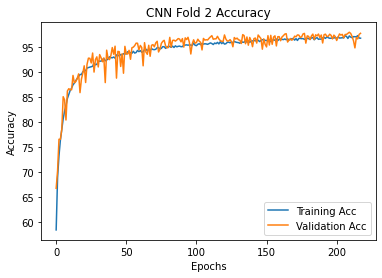

In [8]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_1.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('CNN Fold 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 3

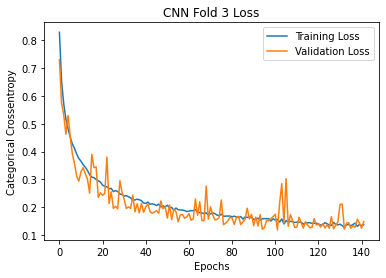

In [9]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_2.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('CNN Fold 3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

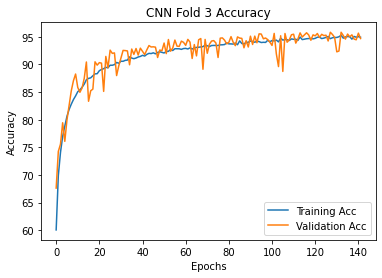

In [10]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_2.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('CNN Fold 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 4

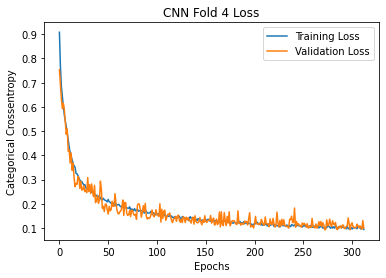

In [11]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_3.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('CNN Fold 4 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

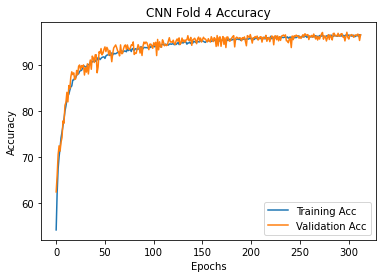

In [12]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_3.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('CNN Fold 4 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 5

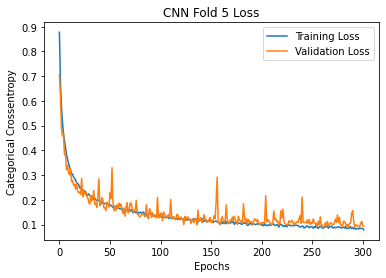

In [13]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_4.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('CNN Fold 5 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

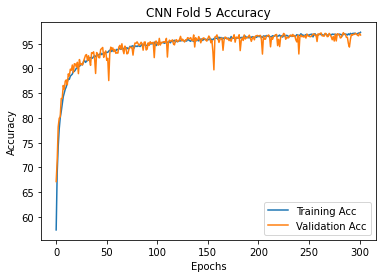

In [14]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_4.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('CNN Fold 5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Final Accuracy and Loss

In [15]:
final_result = pd.concat([history_fold_0[-1:],
                          history_fold_1[-1:],
                          history_fold_2[-1:],
                          history_fold_3[-1:],
                          history_fold_4[-1:],
                         ])
final_result.columns = ['Last Training Loss (Crossentropy)', 'Last Training Accuracy', 'Last Validation Loss (Crossentropy)', 'Last Validation Accuracy']
final_result = final_result.reset_index(drop = True)
final_result.index += 1 
final_result.index.name = 'Fold'
final_result['Last Training Accuracy'] *= 100
final_result['Last Validation Accuracy'] *= 100
final_result['Last Training Loss (Crossentropy)'] = final_result['Last Training Loss (Crossentropy)'].round(5)
final_result['Last Validation Loss (Crossentropy)'] = final_result['Last Validation Loss (Crossentropy)'].round(5)
final_result['Last Training Accuracy'] = final_result['Last Training Accuracy'].round(2)
final_result['Last Validation Accuracy'] = final_result['Last Validation Accuracy'].round(2)

final_result

,Last Training Loss (Crossentropy),Last Training Accuracy,Last Validation Loss (Crossentropy),Last Validation Accuracy
Fold,,,,
1,0.12278,95.51,0.12754,95.74
2,0.09246,96.71,0.06887,97.69
3,0.13727,94.93,0.14838,94.70
4,0.09409,96.56,0.09962,96.60
5,0.07844,97.32,0.09444,96.76


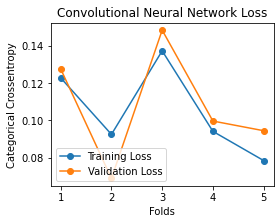

In [16]:
plt.figure(figsize = [4,3])
plt.plot(final_result.loc[:, ['Last Training Loss (Crossentropy)', 'Last Validation Loss (Crossentropy)']],'o-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Convolutional Neural Network Loss')
plt.xticks(np.arange(1,6,1))
plt.xlabel('Folds')
plt.ylabel('Categorical Crossentropy')
plt.show()

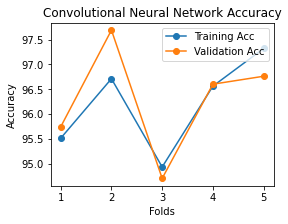

In [17]:
plt.figure(figsize = [4,3])
plt.plot(final_result.loc[:, ['Last Training Accuracy', 'Last Validation Accuracy']],'o-')
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('Convolutional Neural Network Accuracy')
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.show()